In [1]:
# importing packages and modules
import numpy as np
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from io_utils import *
from utils import *
from plotting_utils import *
from analysis_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm
sns.set_context("talk")
# ignore warning for mean of empty slice (nan)
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']
colorsStates = ['tab:orange','tab:blue','tab:green','tab:purple', 'tab:brown']
myFeatures = ['stimulus','bias','previous choice','previous correct side']
ibl_data_path = '../data_IBL'
# load dataset with all animals
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [2]:
# identities of labs
subjectsAll = []
colors_labs = ['tab:brown','tab:red','tab:purple']
labChosen =  ['angelakilab','churchlandlab','wittenlab']
dict_subjects = {'angelakilab':[],'churchlandlab':[],'wittenlab':[]}

for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')
 
lab_identity = np.ones((len(subjectsAll))).astype(int) * -1

for subject_idx in range(len(subjectsAll)):
    subject = subjectsAll[subject_idx]
    for z in range(len(labChosen)):
        lab = labChosen[z]
        subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
        if subject in subjects:
            lab_identity[subject_idx] = z

In [3]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 0
priorDirP = [10,1]
maxiter = 300
splitFolds = 5
D = 4 # number of features
sessStop = None # last session to use in fitting
pTanh = 5 # tanh transformation
signedStimulus = True # signed stimulus contrast
fit_init_states = False # not fitting initial latent
K_max = 5 # maximum number of states
bestSigmaInd = 8  # Choosing best sigma index across animals
bestAlphaInd = 2  # Choosing best sigma index across animals

# Figure 6A

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


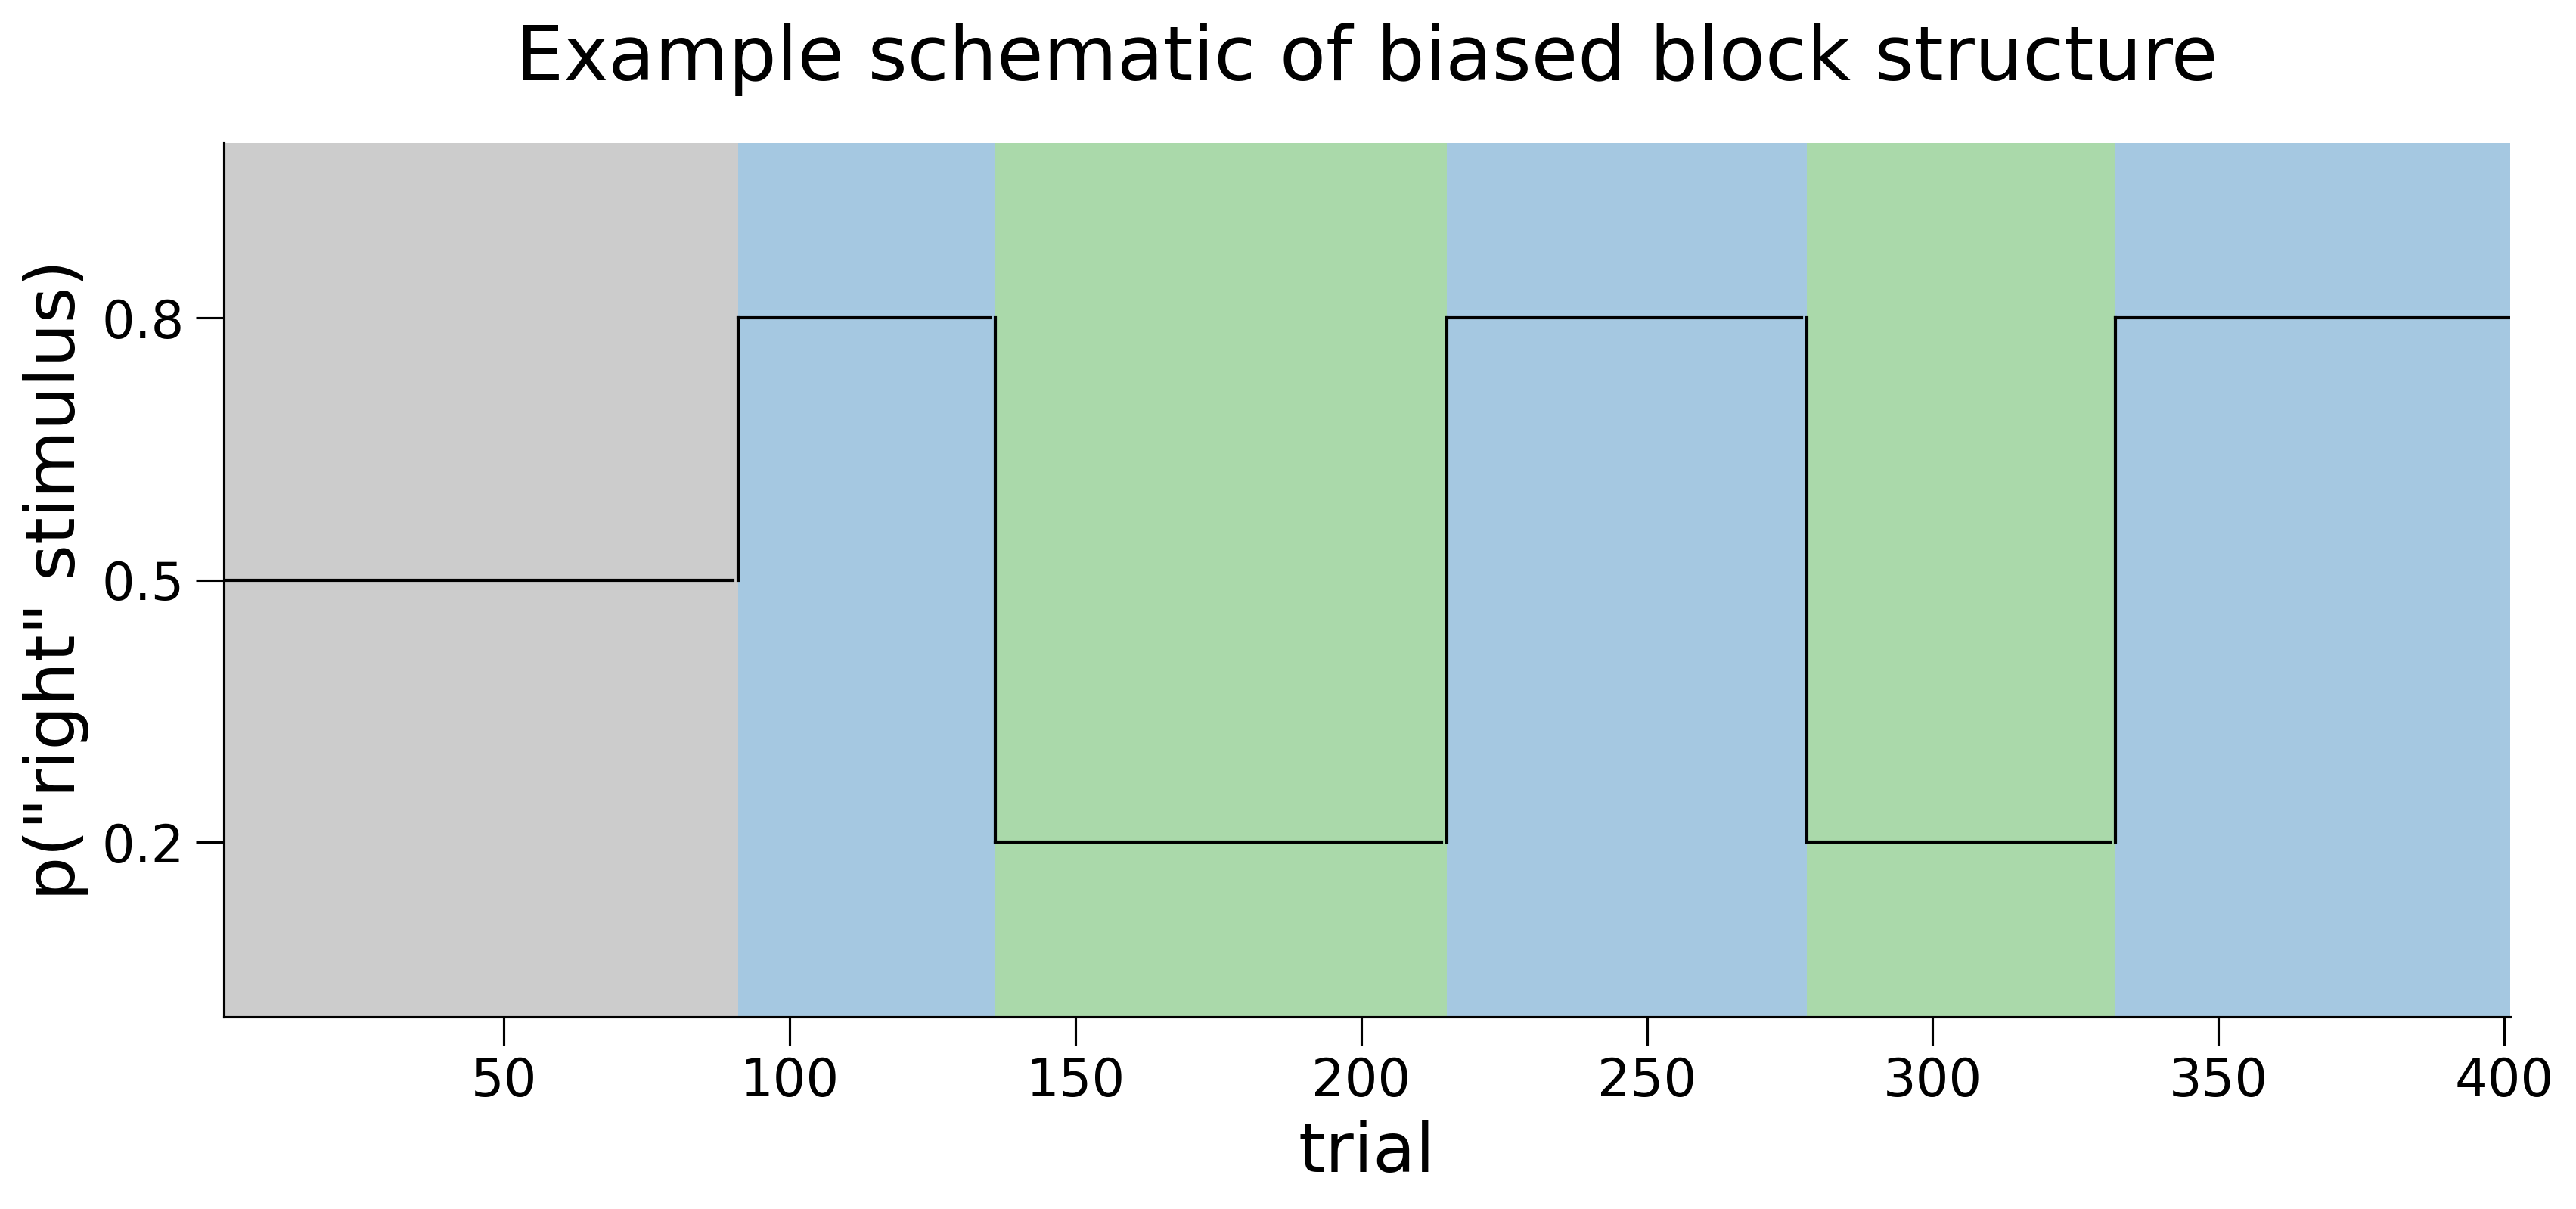

In [4]:
from matplotlib.patches import Rectangle
fig, axes = plt.subplots(1, figsize = (13,5), sharex=True, dpi=300) 
N_trials = 408

axes.plot(range(1,91), np.ones((90)) * 0.5, color='black', linewidth=1)
axes.plot([91,91],[0.5,0.8], color='black', linewidth=1)
axes.plot(range(91,136), np.ones((45)) * 0.8, color='black', linewidth=1)
axes.plot([136,136],[0.2,0.8], color='black', linewidth=1)
axes.plot(range(136,215), np.ones((79)) * 0.2, color='black', linewidth=1)
axes.plot([215,215],[0.2,0.8], color='black', linewidth=1)
axes.plot(range(215,278), np.ones((63)) * 0.8, color='black', linewidth=1)
axes.plot([278,278],[0.2,0.8], color='black', linewidth=1)
axes.plot(range(278,332), np.ones((54)) * 0.2, color='black', linewidth=1)
axes.plot([332,332],[0.2,0.8], color='black', linewidth=1)
axes.plot(range(332,408), np.ones((76)) * 0.8, color='black', linewidth=1)

axes.add_patch(Rectangle((1, 0), 90, 1, facecolor='gray', fill=True, alpha=0.4, zorder=0))
axes.add_patch(Rectangle((91, 0), 45, 1, facecolor='tab:blue', fill=True, alpha=0.4, zorder=0))
axes.add_patch(Rectangle((136, 0), 79, 1, facecolor='tab:green', fill=True, alpha=0.4, zorder=0))
axes.add_patch(Rectangle((215, 0), 63, 1, facecolor='tab:blue', fill=True, alpha=0.4, zorder=0))
axes.add_patch(Rectangle((278, 0), 54, 1, facecolor='tab:green', fill=True, alpha=0.4, zorder=0))
axes.add_patch(Rectangle((332, 0), 76, 1, facecolor='tab:blue', fill=True, alpha=0.4, zorder=0))

axes.set_ylabel('p("right" stimulus)', size=22)
axes.set_ylim(0,1)
axes.set_yticks([0.2,0.5,0.8],[0.2,0.5,0.8])
axes.set_xlabel('trial', size=22)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_xticks(range(50,450,50),range(50,450,50))
axes.set_title('Example schematic of biased block structure', size=24, pad=20)
axes.set_xlim(1,401)
plt.savefig(f'../figures/Example_session_block_structure.eps', format='eps', bbox_inches='tight', dpi=300)

In [5]:
# load fitted parameters from best partial and dynamic 3-state models
K = 3 # number of states to proceed with analysis
allP_best_partial = np.zeros((len(subjectsAll), K, K))   
allW_best_partial = np.empty((len(subjectsAll)), dtype=object)
allP_best_dynamic = np.empty((len(subjectsAll)), dtype=object)
allW_best_dynamic = np.empty((len(subjectsAll)), dtype=object)

for idx in range(0, len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, signedStimulus=signedStimulus, pTanh=pTanh)
    N = x.shape[0]

    # parameters for best partial model
    P_fold = np.empty((splitFolds), dtype=object)
    W_fold = np.empty((splitFolds), dtype=object)
    for fold in range(splitFolds):
        data_partial = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        P_fold[fold] = data_partial['allP']
        W_fold[fold] = data_partial['allW']
    allP_best_partial[idx] = np.mean(P_fold, axis=0)[bestSigmaInd,0] 
    allW_best_partial[idx], _ = reshape_parameters_session_to_trials(np.mean(W_fold, axis=0)[bestSigmaInd], np.mean(P_fold, axis=0)[bestSigmaInd], sessInd)

    # parameters for best dynamic model
    P_fold = np.empty((splitFolds), dtype=object)
    W_fold = np.empty((splitFolds), dtype=object)
    for fold in range(splitFolds):
        data_dynamic = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        P_fold[fold] = data_dynamic['allP']
        W_fold[fold] = data_dynamic['allW']
    allW_best_dynamic[idx], allP_best_dynamic[idx] = reshape_parameters_session_to_trials(np.mean(W_fold, axis=0)[bestAlphaInd], np.mean(P_fold, axis=0)[bestAlphaInd], sessInd)


In [6]:
# computing empirical task performance in right vs left blocks
rightBiasPerformance = np.ma.empty((len(subjectsAll)), dtype=object)
# rightBiasPerformance.mask = True
leftBiasPerformance = np.ma.empty((len(subjectsAll)), dtype=object)
# leftBiasPerformance.mask = True

for idx in range(0, len(subjectsAll)):
    subject = subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, signedStimulus=signedStimulus, pTanh=pTanh)
    biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    N = x.shape[0]

    correctChoice = (y == correctSide).astype(int) # 1 if animal made correct choice
    sess = len(sessInd)-1
    rightBiasPerformance[idx] = np.zeros((sess))
    leftBiasPerformance[idx] = np.zeros((sess))
    for s in range(0,sess):
        biasedRight = (biasedBlockTrials[sessInd[s]:sessInd[s+1]]==1)
        if biasedRight.sum() > 0:
            rightBiasPerformance[idx][s] = correctChoice[sessInd[s]+np.argwhere(biasedRight==True)].sum() / biasedRight.sum()
        else: 
            rightBiasPerformance[idx][s] = np.nan
        
        biasedLeft = (biasedBlockTrials[sessInd[s]:sessInd[s+1]]==-1)
        if biasedLeft.sum() > 0:
            leftBiasPerformance[idx][s] = correctChoice[sessInd[s]+np.argwhere(biasedLeft==True)].sum() / biasedLeft.sum()
        else: 
            leftBiasPerformance[idx][s] = np.nan


# Figure 6B

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


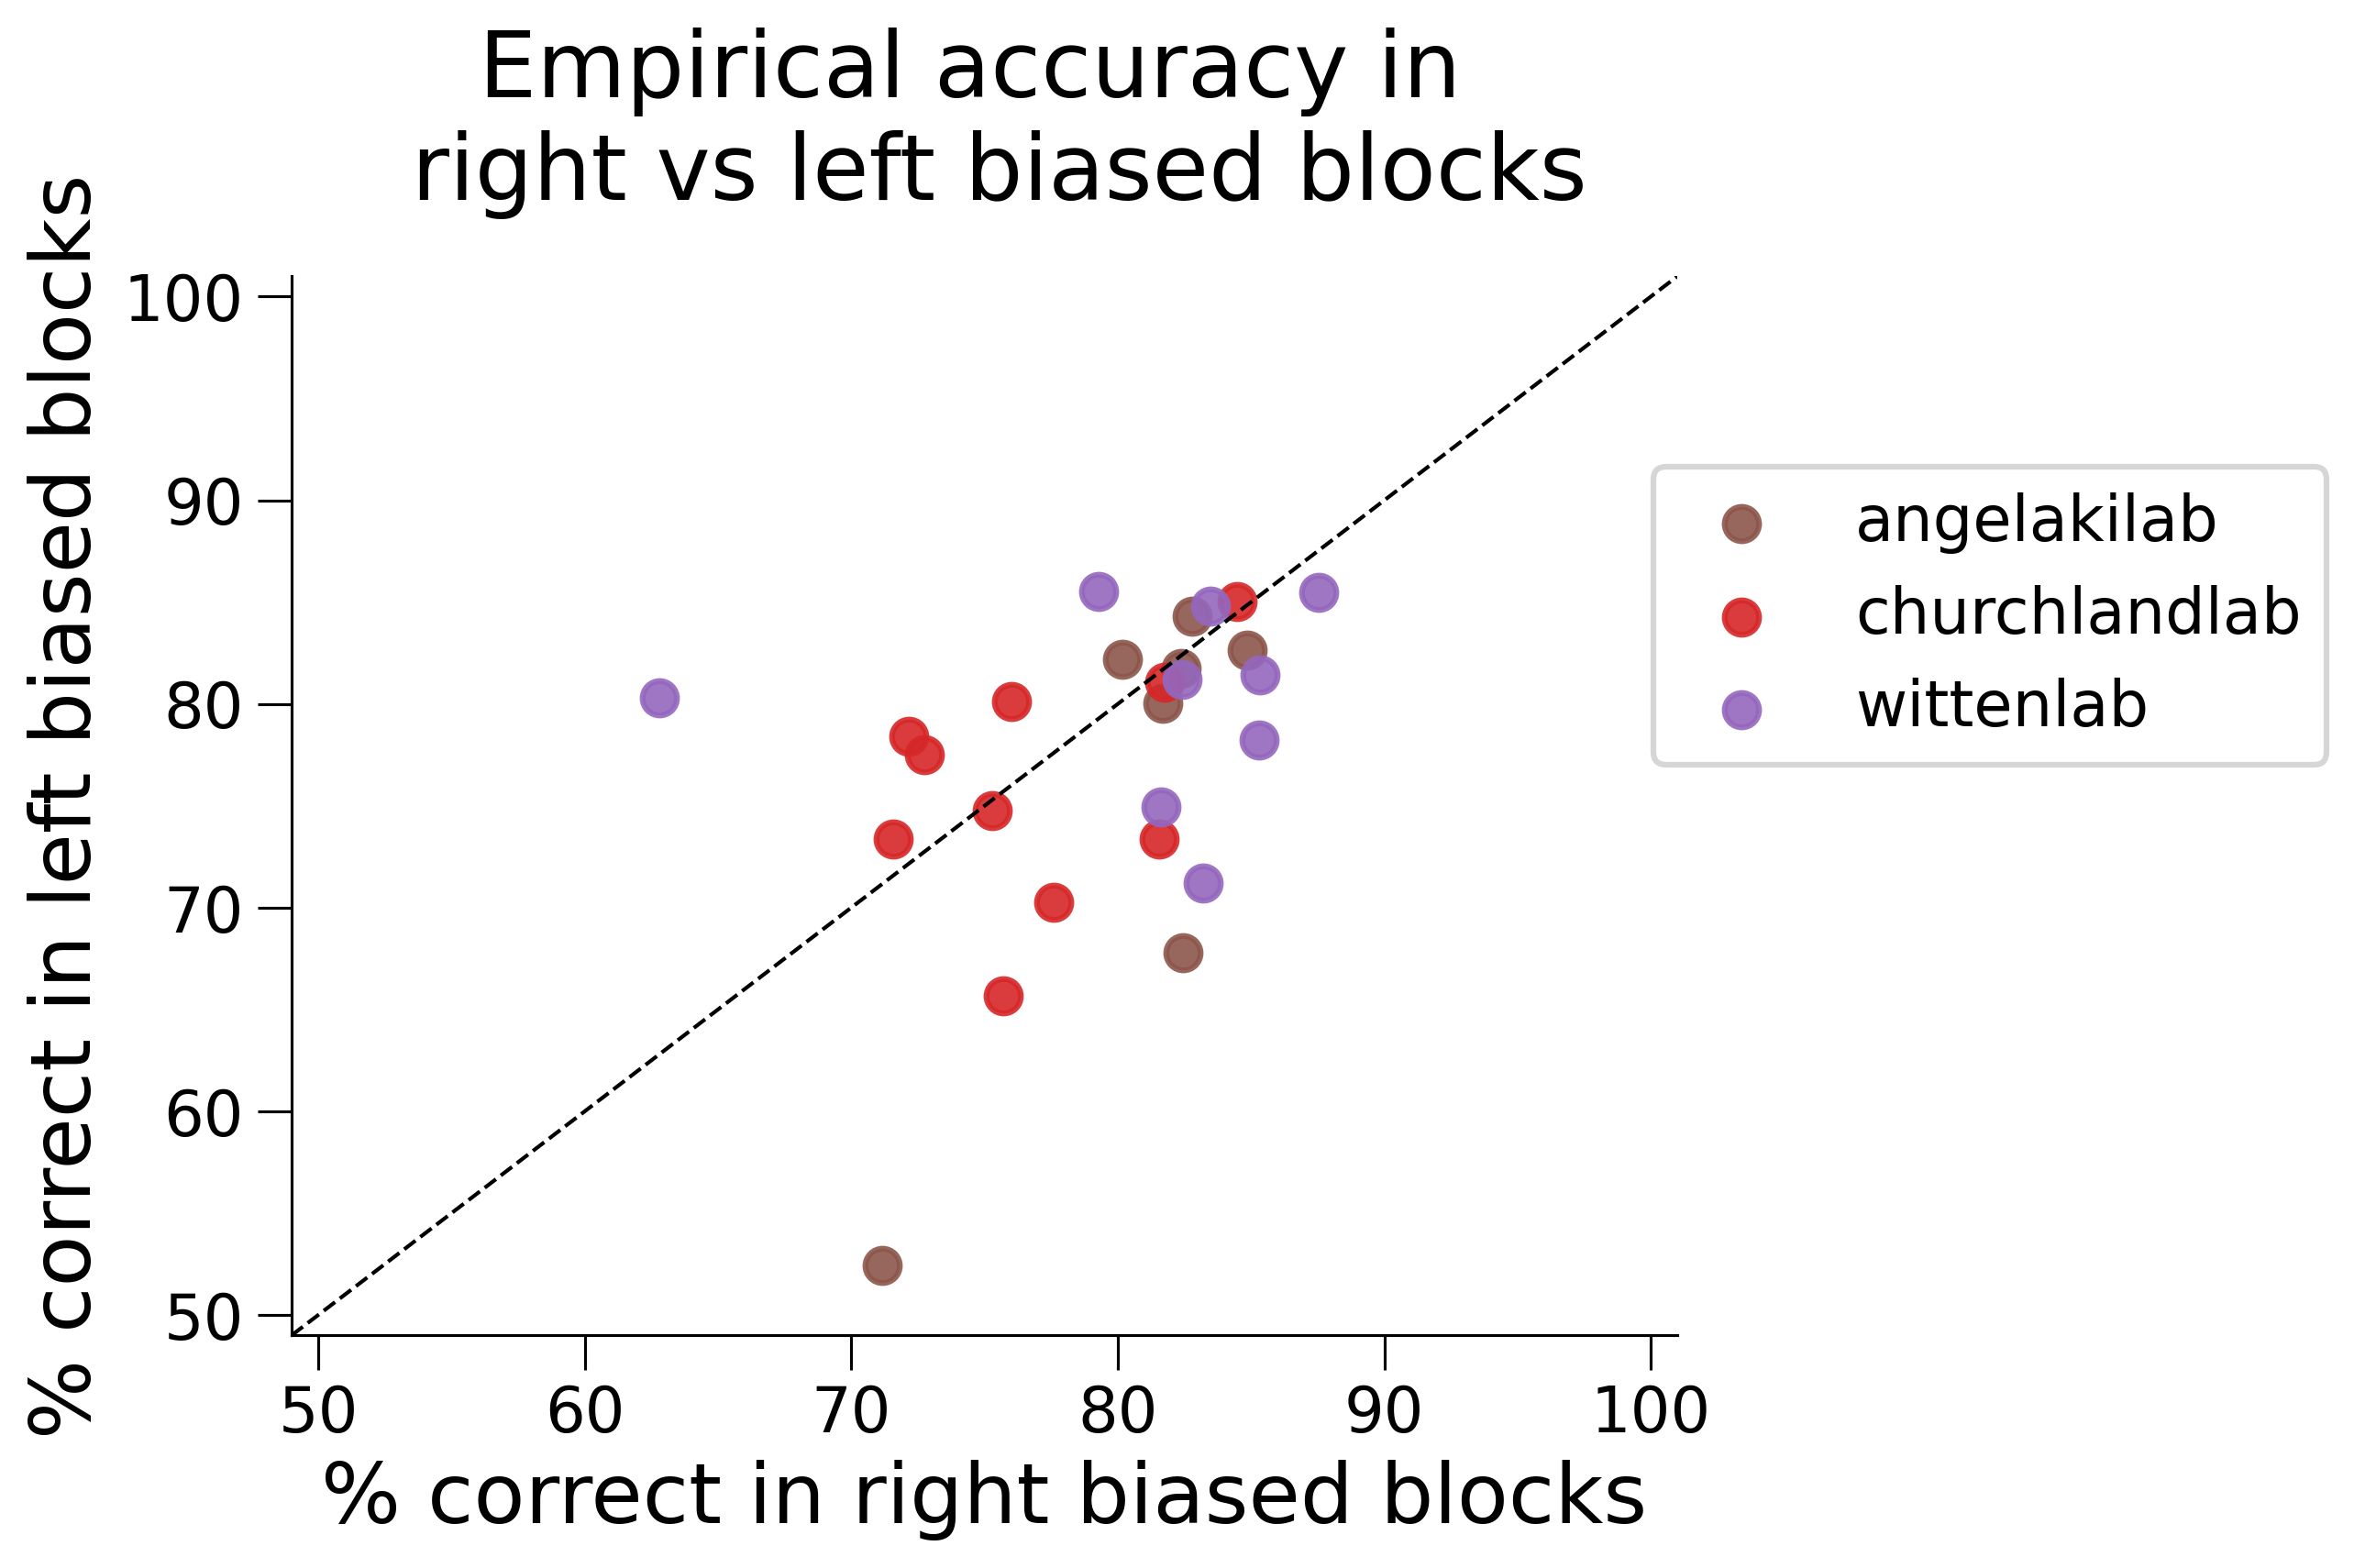

In [7]:
# plotting animal's performance on right vs left biased blocks
fig, axes = fig, axes = plt.subplots(1, figsize = (6.5,5), dpi=300)
axes.set_xlabel('% correct in right biased blocks', size=22)
axes.set_ylabel('% correct in left biased blocks', size=22)
for idx in range(0,len(subjectsAll)):
    if idx in [0,15,30]:
        axes.scatter(np.nanmean(rightBiasPerformance[idx]) * 100, np.nanmean(leftBiasPerformance[idx]) * 100, c=colors_labs[int(lab_identity[idx])], alpha=0.9, label=labChosen[int(lab_identity[idx])])
    else:
        axes.scatter(np.nanmean(rightBiasPerformance[idx]) * 100, np.nanmean(leftBiasPerformance[idx]) * 100, color=colors_labs[int(lab_identity[idx])], alpha=0.9)
axes.set_xlim(49,101)
axes.set_ylim(49,101)
axes.plot([0, 1], [0, 1], transform=axes.transAxes, linestyle='dashed', color='black', linewidth=1)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_title('Empirical accuracy in \n right vs left biased blocks', size=24, pad=20)
axes.legend(bbox_to_anchor=(0.96, 0.85))
plt.savefig(f'../figures/Correct_Right_Vs_Left_ScatterPlot.eps', format='eps', bbox_inches='tight', dpi=300)

In [8]:
# compute observation probabilities (probability of a choice given state and task covariates)
allPhi = np.empty((len(subjectsAll)), dtype=object) 
for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, signedStimulus=signedStimulus, pTanh=pTanh)
    N = sessInd[-1]
    dGLMHMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,2)
    allPhi[idx] = dGLMHMM.observation_probability(x, allW_best_dynamic[idx])

# Computing posterior probability of latents across animals (what inferred state the animal is in at each trial)
allGamma = np.empty((len(subjectsAll)), dtype=object)
truepi = np.ones((K))
for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
    N = sessInd[-1]
    presentAll = np.ones((N))
    dGLM_HMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,2)
    allGamma[idx] = dGLM_HMM.get_posterior_latent(allP_best_dynamic[idx], truepi, allW_best_dynamic[idx], x, y, presentAll, sessInd, sortedStateInd=None)

AttributeError: 'dynamic_GLMHMM' object has no attribute 'get_posterior_latent'

In [ ]:
# Computing per-state occupancy and accuracy
allStateCount = np.empty((len(subjectsAll)), dtype=object)
allStateCorrect = np.empty((len(subjectsAll)), dtype=object)
allOverallCorrect = np.empty((len(subjectsAll)), dtype=object)
blocksStateRight = np.empty((len(subjectsAll)), dtype=object)
blocksStateLeft = np.empty((len(subjectsAll)), dtype=object)
fig, axes = plt.subplots(1, figsize = (14,5))#, dpi=400)
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, signedStimulus=signedStimulus, pTanh=pTanh)
    biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    
    # Plotting task occupancy of each state across sessions
    axes.set_title(subject)
    allStateCount[idx] = plot_state_occupancy_sessions(allGamma[idx], sessInd, axes, colors=colorsStates)

    # plotting task accuracy in each state across sessions
    axes.set_title(subject)
    _, _, allOverallCorrect[idx], allStateCorrect[idx] = accuracy_states_sessions(allGamma[idx], allPhi[idx], y, correctSide, sessInd)

    blocksStateRight[idx], blocksStateLeft[idx] = plot_aligned_fraction_blocks_state(allGamma[idx], sessInd, biasedBlockTrials, biasedBlockSession, axes)
    axes.axvline(firstBlockSession+1, color='gray', zorder=0)
plt.close()


# Figure 6C

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


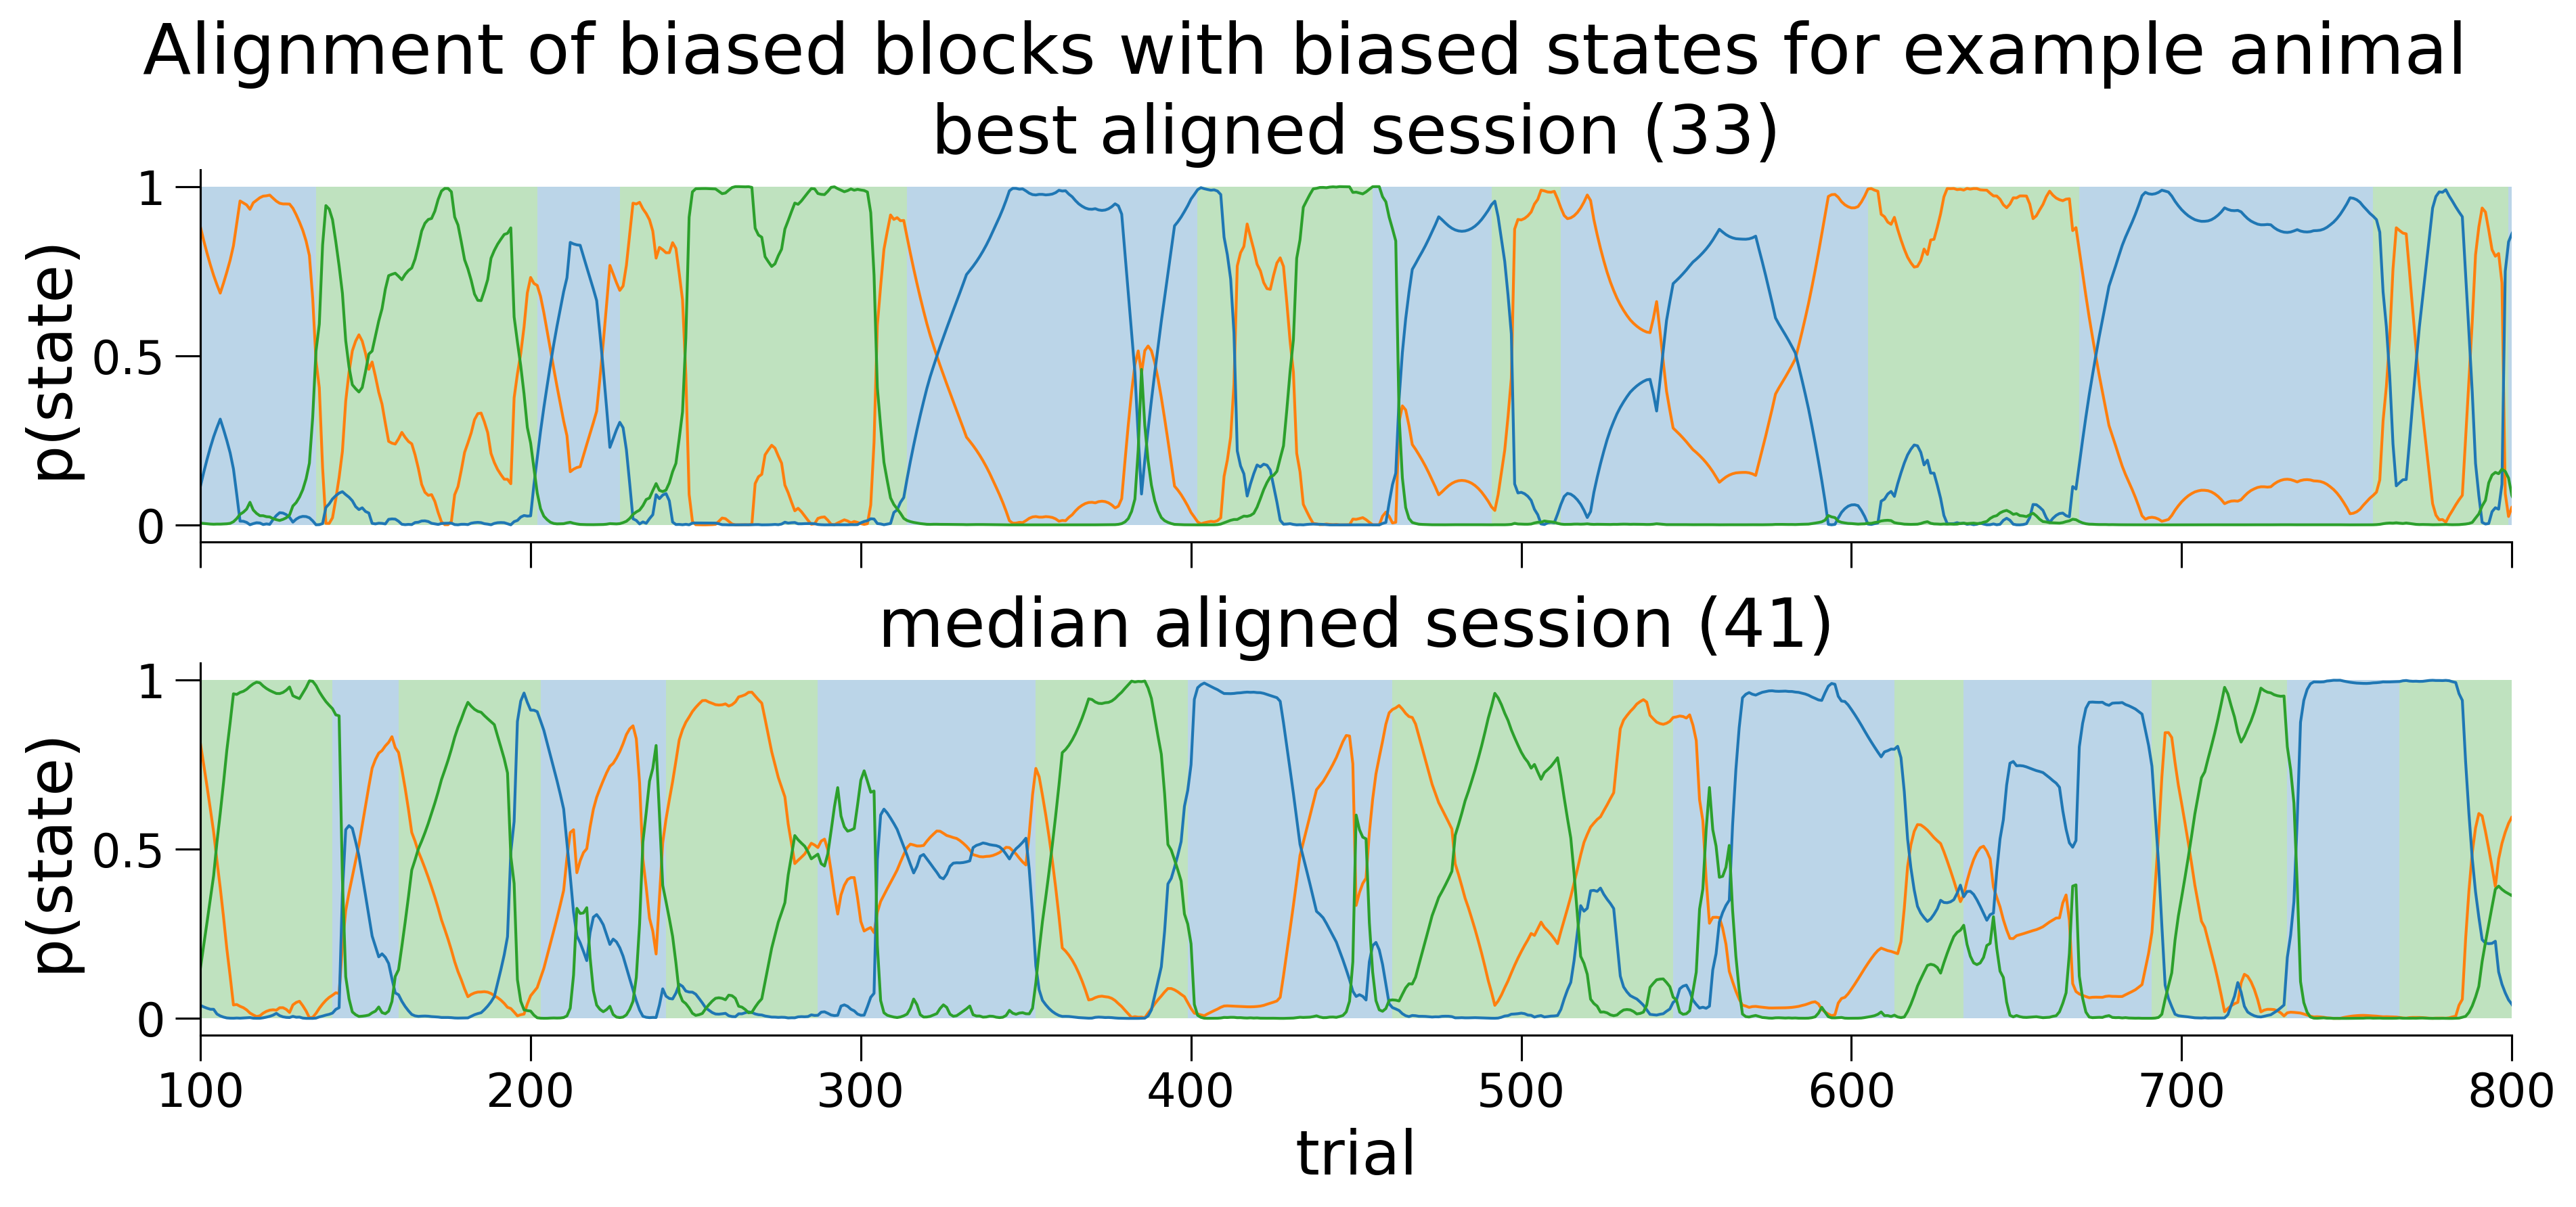

In [ ]:
example_subject = 'ibl_witten_015'
example_idx_subject = 30
subject = subjectsAll[example_idx_subject]
x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    
sessionsInterest = [32,40] # best aligned session and median aligned session for example animal
dict_colors = {0:'gray',1:'tab:blue',-1:'tab:green'}
fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(13,5.5), dpi=300, sharex=True)
fig.tight_layout(pad=1.5)
plot_posteior_latent(allGamma[example_idx_subject], sessInd, axes, sessions = sessionsInterest, linewidth=1)
for s in range(0,len(sessionsInterest)):
    sess = sessionsInterest[s]
    flag = 0
    old = sessInd[sess]
    for t in range(sessInd[sess],sessInd[sess+1]):
        if biasedBlockTrials[t] != flag:
            axes[s].add_patch(Rectangle((old-sessInd[sess], 0), t-old, 1, facecolor=dict_colors[flag], fill=True, alpha=0.3, zorder=0))
            old = t
            flag = biasedBlockTrials[t]
    # last biased block
    axes[s].add_patch(Rectangle((old-sessInd[sess], 0), sessInd[sess+1]-1-old, 1, facecolor=dict_colors[flag], fill=True, alpha=0.3, zorder=0))       
    
    axes[s].set_xlim(100,800)
    axes[s].spines[['right', 'top']].set_visible(False)
    axes[s].spines[['left', 'bottom']].set_linewidth(0.75)
    axes[s].xaxis.set_tick_params(width=0.75)
    axes[s].yaxis.set_tick_params(width=0.75)
    axes[s].get_legend().remove()
    axes[s].set_ylabel('p(state)', size=22)
    axes[s].set_yticks([0,0.5,1],[0,0.5,1])
axes[0].set_title(f'best aligned session ({sessionsInterest[0]+1})', size=24)
axes[1].set_title(f'median aligned session ({sessionsInterest[1]+1})', size=24)
axes[-1].set_xlabel('trial', size=22)
fig.suptitle('Alignment of biased blocks with biased states for example animal', size=25, y=1.05)
# fig.tight_layout()
plt.savefig(f'../figures/posterior_latent_example-sessions_{subject}_biased-blocks.eps', format='eps', bbox_inches='tight', dpi=300)


# Figure 6D

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


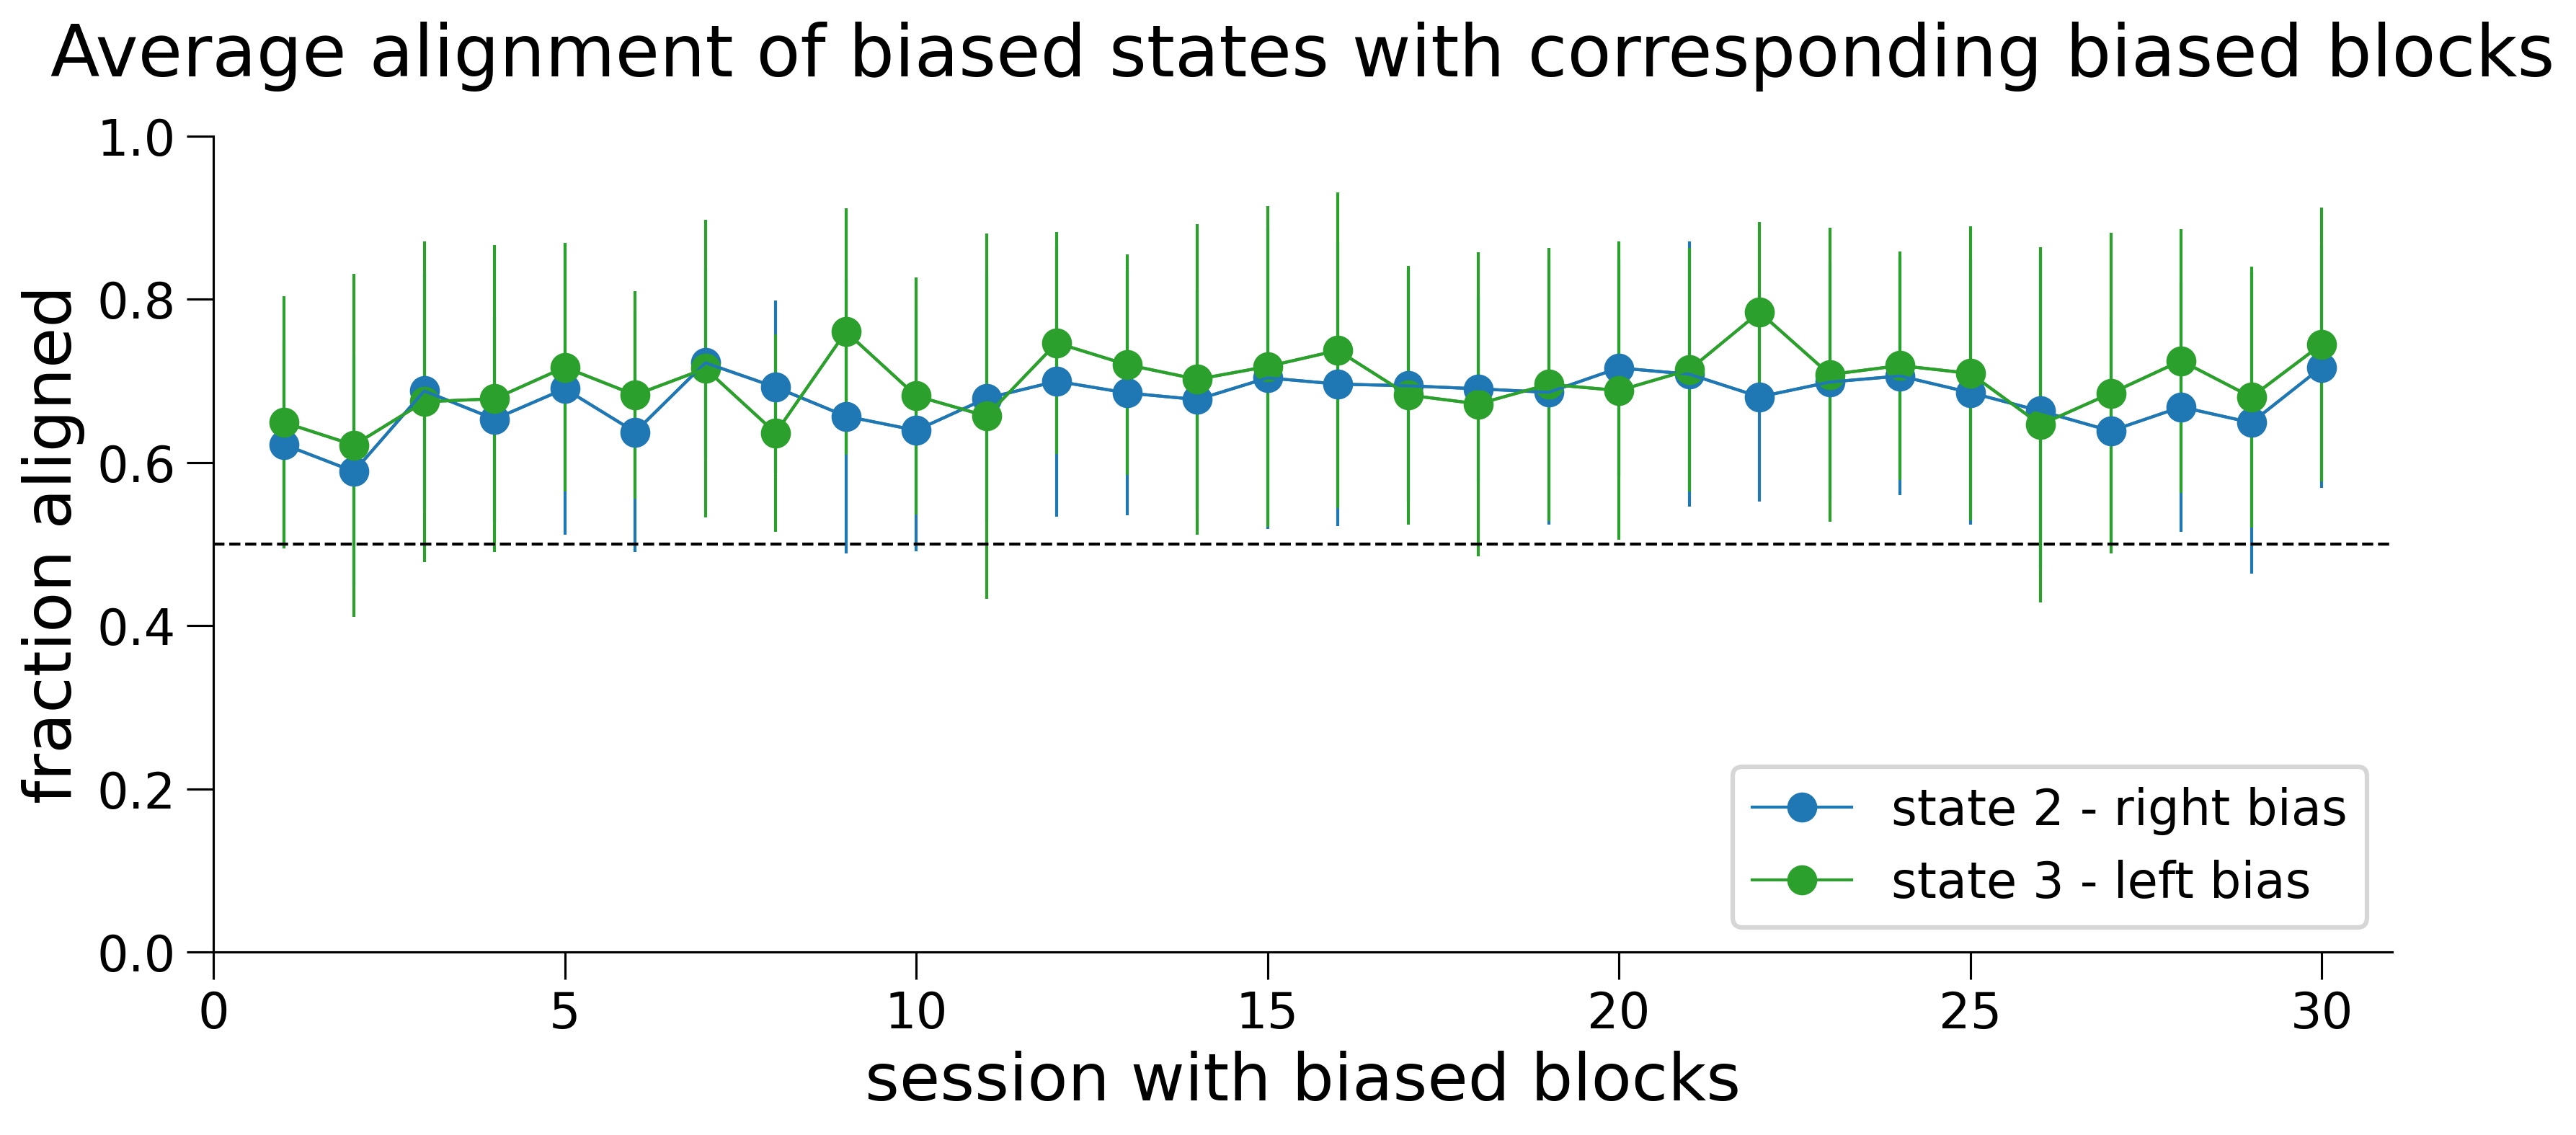

In [ ]:
# Average across animals of bias-block alignment with first biased session aligned across animals
maxSess = 30
arrAlignRight = np.ma.empty((maxSess,len(subjectsAll)))
arrAlignRight.mask = True
arrAlignLeft = np.ma.empty((maxSess,len(subjectsAll)))
arrAlignLeft.mask = True

fig, axes = plt.subplots(1, figsize = (13,5), dpi=300)
axes.set_title('Average alignment of biased states with corresponding biased blocks', size=24, pad=20)
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
    _, _, _, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    if (np.isnan(firstBlockSession) == False):
        stop = min(len(sessInd)-1, firstBlockSession+maxSess)
        arrAlignRight[:stop-firstBlockSession, idx] = blocksStateRight[idx][firstBlockSession:stop]
        arrAlignLeft[:stop-firstBlockSession, idx] = blocksStateLeft[idx][firstBlockSession:stop]
    
    # plotting individual lines for each animal
    # axes.plot(range(1,maxSess+1), arrAlignRight[:,idx], '-', color=colorsStates[1], alpha=0.1, linewidth=1)
    # axes.plot(range(1,maxSess+1),  arrAlignLeft[:,idx], '-', color=colorsStates[2], alpha=0.1, linewidth=1)

axes.errorbar(range(1,maxSess+1), np.nanmean(arrAlignRight[:,:], axis=1), yerr=np.nanstd(arrAlignRight[:,:], axis=1), color=colorsStates[1], linewidth=1)
axes.errorbar(range(1,maxSess+1), np.nanmean(arrAlignLeft[:,:], axis=1), yerr=np.nanstd(arrAlignLeft[:,:], axis=1), color=colorsStates[2], linewidth=1)
axes.plot(range(1,maxSess+1), np.nanmean(arrAlignRight[:,:], axis=1), '-o', color=colorsStates[1], label='state 2 - right bias', linewidth=1)
axes.plot(range(1,maxSess+1), np.nanmean(arrAlignLeft[:,:], axis=1), '-o', color=colorsStates[2], label='state 3 - left bias', linewidth=1)
axes.legend(loc='lower right')
axes.set_xlim(0,maxSess+1)
axes.axhline(0.5,color='black',linestyle='dashed', linewidth=1)
axes.set_ylim(0,1)
axes.set_xlabel('session with biased blocks', size=22)
axes.set_ylabel('fraction aligned', size=22)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
plt.savefig(f'../figures/Fraction_Aligned_States-and-Blocks_allAnimals.eps', format='eps',  bbox_inches='tight', dpi=300)


# Figure 6E

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


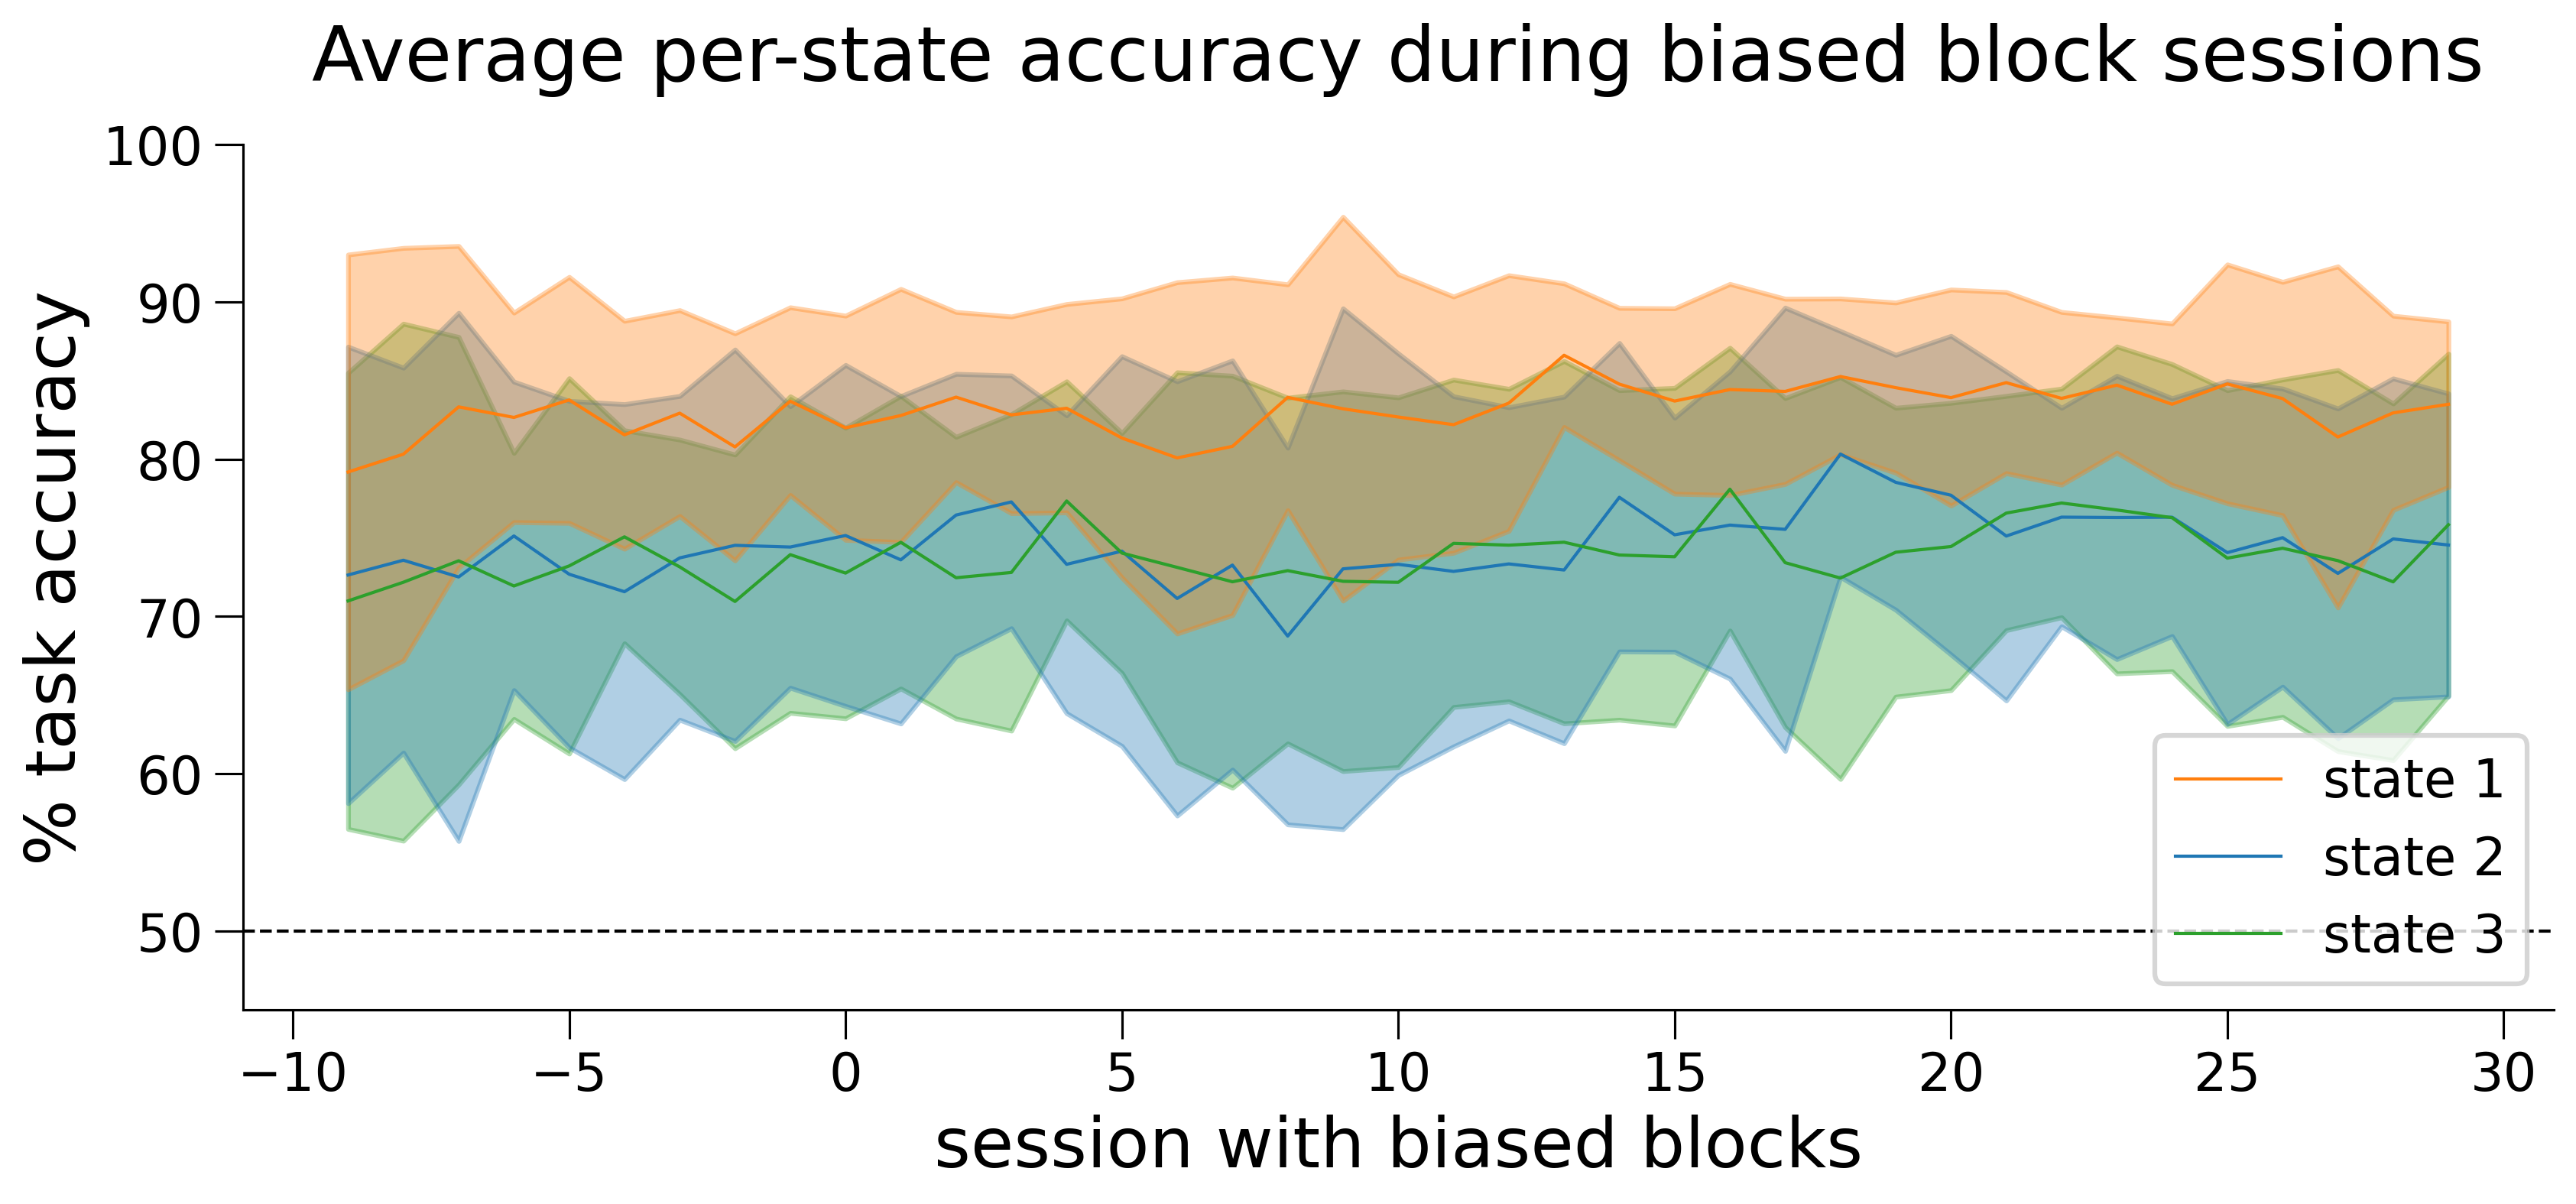

In [ ]:
# computing per-state accuracy aligned to start of biased blocks
arrStateCorrect = np.ma.empty((maxSess+9,K,len(subjectsAll)))
arrStateCorrect.mask = True

for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
    _, _, _, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)

    if (np.isnan(firstBlockSession) == False and firstBlockSession >= 9):
        stop = min(len(sessInd)-1, firstBlockSession+maxSess)
        arrStateCorrect[:stop-firstBlockSession+9, :K, idx] = allStateCorrect[idx][firstBlockSession-9:stop]

fig, axes = plt.subplots(1, figsize = (13, 5), dpi=300) 
axes.axhline(50, color='black', linestyle='dashed', linewidth=1)
for k in range(0,K):
    axes.plot(range(-9,maxSess), np.nanmean(arrStateCorrect[:,k,:], axis=1), color=colorsStates[k], linewidth=1, label=f'state {k+1}', zorder=3)
    axes.fill_between(range(-9,maxSess), np.nanmean(arrStateCorrect[:,k,:], axis=1)-np.nanstd(arrStateCorrect[:,k,:], axis=1), np.nanmean(arrStateCorrect[:,k,:], axis=1)+np.nanstd(arrStateCorrect[:,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])
axes.set_ylabel('% task accuracy', size=22)
axes.set_xlabel('session with biased blocks', size=22)
axes.set_ylim(45,100)
axes.legend(loc='lower right')
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_title('Average per-state accuracy during biased block sessions', size=24, pad=20)
plt.savefig(f'../figures/Accuracy_states_allAnimals_biasblocks.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 6F

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


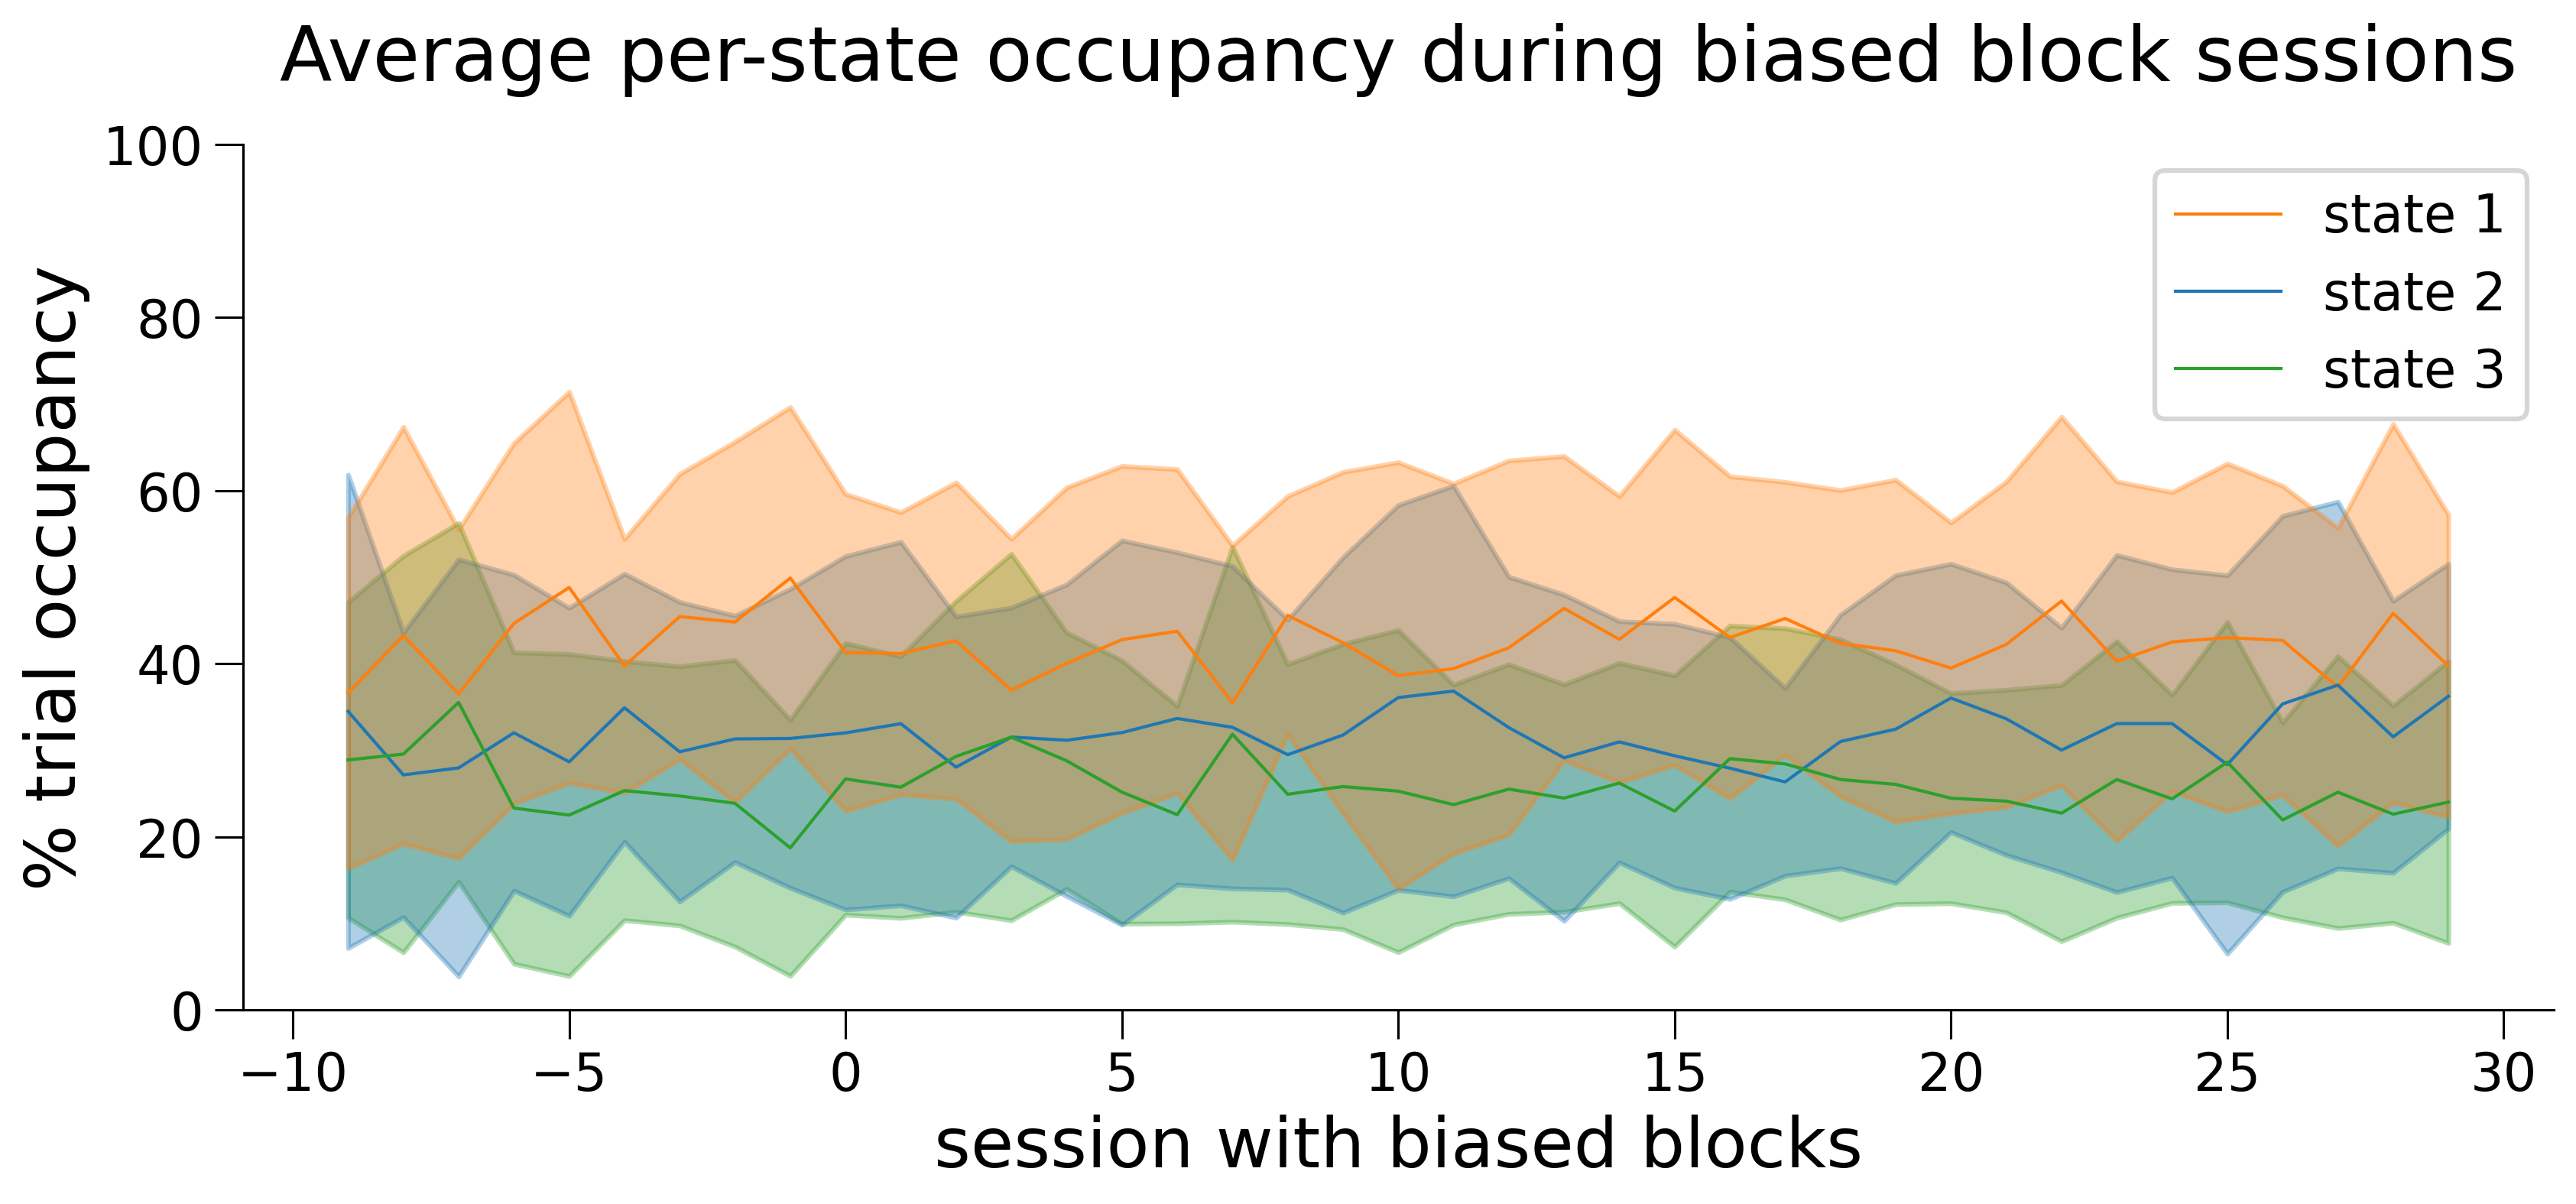

In [ ]:
# computing per-state occupancy aligned to start of biased blocks
arrStateCount = np.ma.empty((maxSess+9,K,len(subjectsAll)))
arrStateCount.mask = True

for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
    _, _, _, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    if (np.isnan(firstBlockSession) == False and firstBlockSession >= 9):
        stop = min(len(sessInd)-1, firstBlockSession+maxSess)
        arrStateCount[:stop-firstBlockSession+9, :K, idx] = allStateCount[idx][firstBlockSession-9:stop]

fig, axes = plt.subplots(1, figsize = (13, 5), dpi=300) 
for k in range(0,K):
    axes.plot(range(-9,maxSess), np.nanmean(arrStateCount[:,k,:], axis=1), color=colorsStates[k], linewidth=1, label=f'state {k+1}', zorder=3)
    axes.fill_between(range(-9,maxSess), np.nanmean(arrStateCount[:,k,:], axis=1)-np.nanstd(arrStateCount[:,k,:], axis=1), np.nanmean(arrStateCount[:,k,:], axis=1)+np.nanstd(arrStateCount[:,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])
axes.set_ylabel('% trial occupancy', size=22)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_xlabel('session with biased blocks', size=22)
axes.set_ylim(0,100)
axes.legend(loc='upper right')
axes.set_title('Average per-state occupancy during biased block sessions', size=24, pad=20)
plt.savefig(f'../figures/Occupancy_states_allAnimals_biasblocks.eps', format='eps', bbox_inches='tight', dpi=300)


